# Step #1 Load Time Series Data

In [169]:
# https://github.com/flo7up/relataly-public-python-tutorials/blob/master/001%20Time%20Series%20Forecasting%20-%20Forecasting%20US%20Beer%20Sales%20with%20(auto)%20ARIMA.ipynb


# Setting up packages for data manipulation and machine learning
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
# sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})



In [170]:
ab_path = "../data/SPY-Monthly-RSI_3M-Y2001ToNow.csv"
# colx='RSI_3M'
colx='Price'

In [171]:

dfAll = pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
dfAll.rename(columns={'Date/Time':'Date'},inplace=True)
dfAll['Date']=dfAll['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,1 ))
# dfAll.set_index('Date',inplace=True)

df=dfAll[['Date',colx]]
print(df.info())
df.tail()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    263 non-null    datetime64[ns]
 1   Price   263 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.2 KB
None


,Date,Price
258,2022-07-01,411.99
259,2022-08-01,395.18
260,2022-09-01,357.18
261,2022-10-01,386.21
262,2022-11-01,402.33


# Step #2 Visualize the Time-Series and Check it for Stationarity

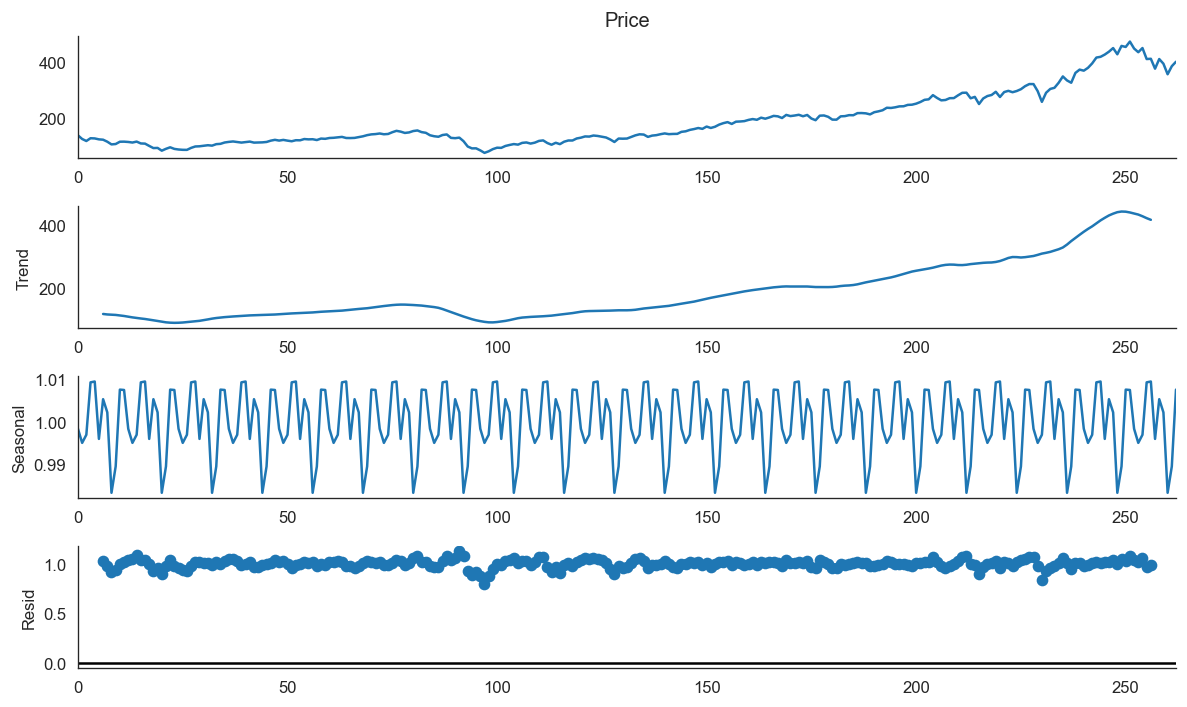

In [172]:
# Decompose the time series
plt.rcParams["figure.figsize"] = (10,6)
result = seasonal_decompose(df[colx], model='multiplicative',period=12)
result.plot()
plt.show()

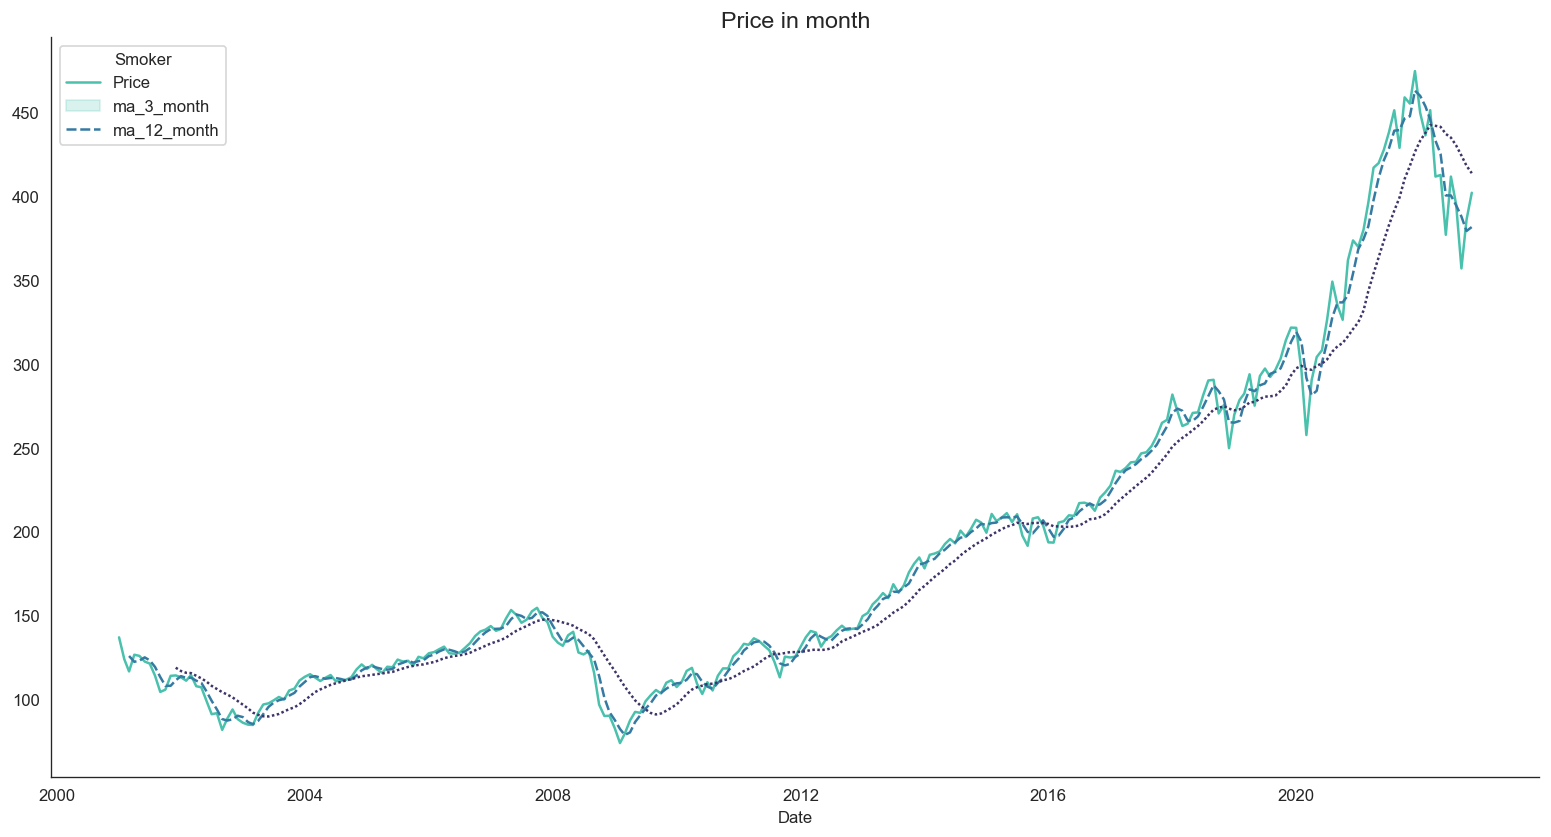

(0.7325322698588641, True)


,Price,ma_3_month,ma_12_month
Date,,,
2022-07-01,411.99,400.723333,435.235000
2022-08-01,395.18,394.806667,430.536667
2022-09-01,357.18,388.116667,424.540000
2022-10-01,386.21,379.523333,418.453333
2022-11-01,402.33,381.906667,414.017500


In [173]:
ma_short=3
ma_long=12

name_ma_short=f'ma_{ma_short}_month'
name_ma_long=f'ma_{ma_long}_month'

def check_stationarity(df_sales, title_string, labels):
    # Visualize the data
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.title(title_string, fontsize=14)
    if df_sales.index.size > 12:
        df_sales[name_ma_short] = df_sales[colx].rolling(window=ma_short).mean()
        df_sales[name_ma_long] = df_sales[colx].rolling(window=ma_long).mean()
        sns.lineplot(data=df_sales[[colx, name_ma_short,name_ma_long]], palette=sns.color_palette("mako_r", 3))
        plt.legend(title='Smoker', loc='upper left', labels=labels)
    else:
        sns.lineplot(data=df_sales[[colx]])
    
    plt.show()
    
    sales = df_sales[colx].dropna()
    # Perform an Ad Fuller Test
    # the default alpha = .05 stands for a 95% confidence interval
    adf_test = pm.arima.ADFTest(alpha = 0.05) 
    print(adf_test.should_diff(sales))
    
df_sales = pd.DataFrame(df[colx], columns=[colx])
df_sales.index = pd.to_datetime(df['Date']) 
title = f"{colx} in month"
labels = [colx, name_ma_short, name_ma_long]
check_stationarity(df_sales, title, labels)

df_sales.tail()

# Step #3 Exemplary Differencing and Autocorrelation

In [174]:
# 3.1 Non-seasonal part
def auto_correlation(df, prefix, lags):
    plt.rcParams.update({'figure.figsize':(7,7), 'figure.dpi':120})
    
    # Define the plot grid
    fig, axes = plt.subplots(3,2, sharex=False)

    # First Difference
    axes[0, 0].plot(df)
    axes[0, 0].set_title('Original' + prefix)
    plot_acf(df, lags=lags, ax=axes[0, 1])

    # First Difference
    df_first_diff = df.diff().dropna()
    axes[1, 0].plot(df_first_diff)
    axes[1, 0].set_title('First Order Difference' + prefix)
    plot_acf(df_first_diff, lags=lags - 1, ax=axes[1, 1])

    # Second Difference
    df_second_diff = df.diff().diff().dropna()
    axes[2, 0].plot(df_second_diff)
    axes[2, 0].set_title('Second Order Difference' + prefix)
    plot_acf(df_second_diff, lags=lags - 2, ax=axes[2, 1])
    plt.tight_layout()
    plt.show()


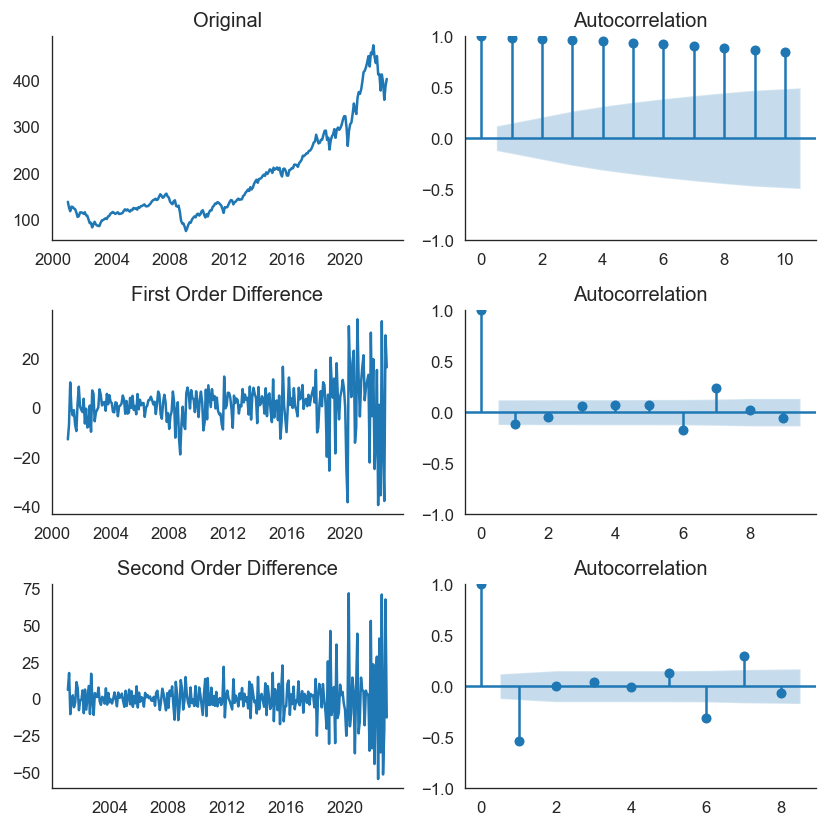

In [178]:
 # 3.1 Seasonal part   
auto_correlation(df_sales[colx], '', 10)

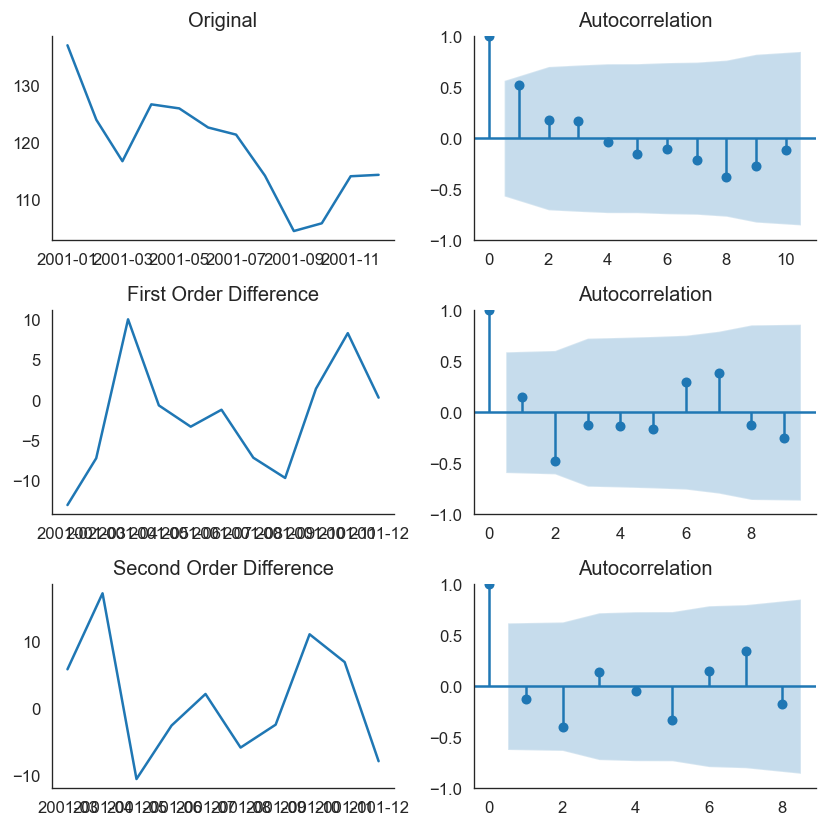

In [179]:
# 3.2 Seasonal part

# Reduce the timeframe to a single seasonal period
df_sales_s = df_sales[colx][0:12]

# Autocorrelation for the seasonal part
auto_correlation(df_sales_s, '', 10)

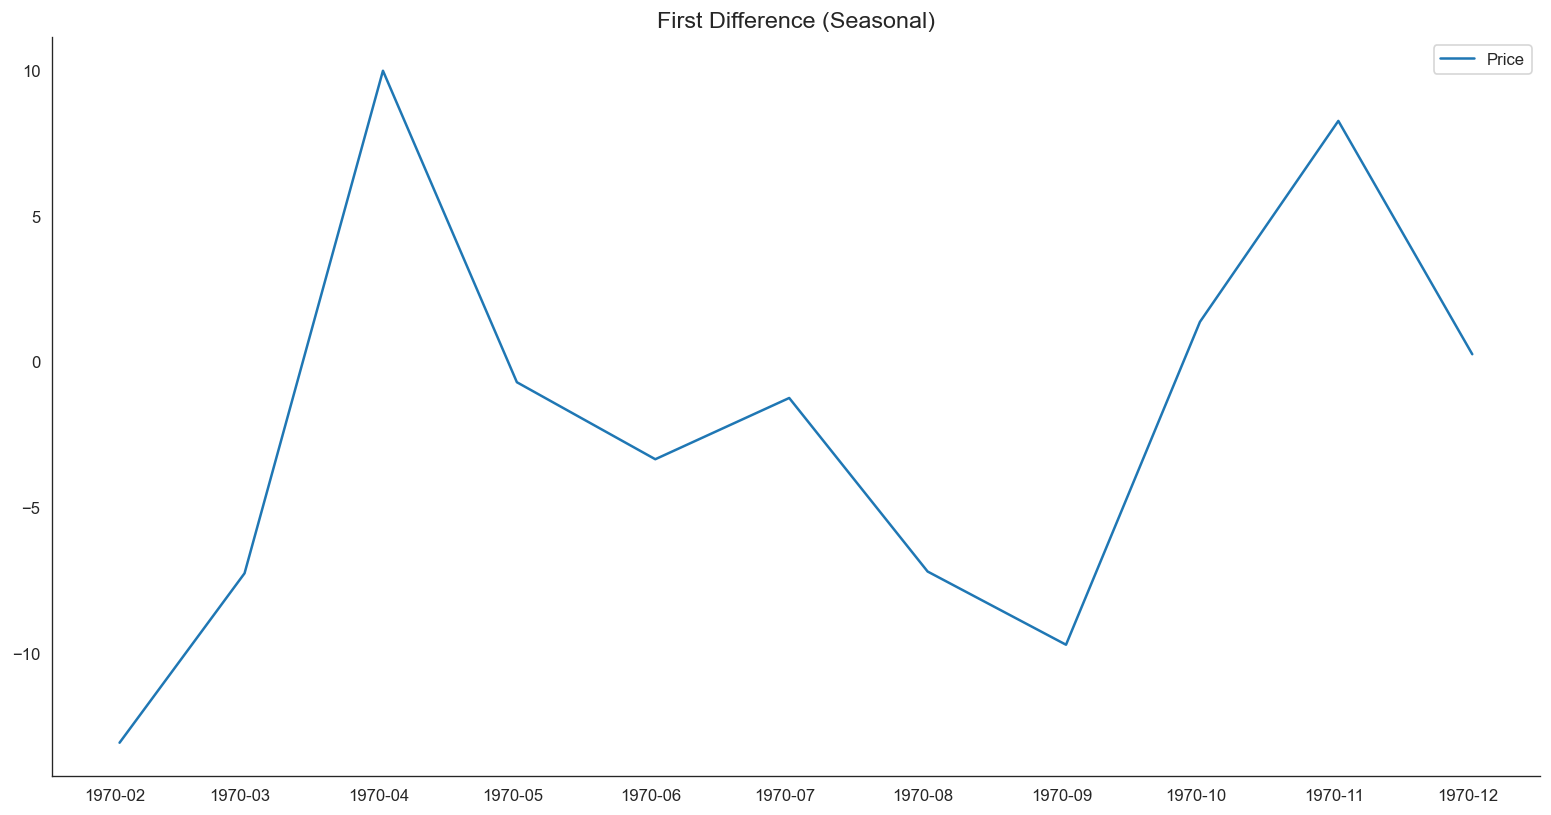

(0.9195584025236213, True)


In [180]:
# Check if the first difference of the seasonal period is stationary
df_diff = pd.DataFrame(df_sales_s.diff())
df_diff.index = pd.date_range(df_sales_s.diff().iloc[1], periods=12, freq='MS') 
check_stationarity(df_diff, "First Difference (Seasonal)", ['difference'])

# Step #4 Finding an Optimal Model with Auto-ARIMA

In [181]:
# split into train and test
pred_periods =6
split_number = df_sales[colx].count() - pred_periods # corresponds to a prediction horizion  of 2,5 years
df_train = pd.DataFrame(df_sales[colx][:split_number]).rename(columns={colx:'y_train'})
df_test = pd.DataFrame(df_sales[colx][split_number:]).rename(columns={colx:'y_test'})

# auto_arima
model_fit = pm.auto_arima(df_train, test='adf', 
                         max_p=3, max_d=3, max_q=3, 
                         seasonal=True, m=12,
                         max_P=3, max_D=2, max_Q=3,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

# summarize the model characteristics
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1846.540, Time=1.81 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1849.173, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1852.144, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1852.034, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1850.909, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1844.690, Time=1.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1843.048, Time=0.76 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1844.672, Time=2.04 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=1844.623, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1851.950, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(3,1,1)(0,0,0)[12] intercept   : 

# Step #5 Simulate the Time Series with in-sample Forecasting

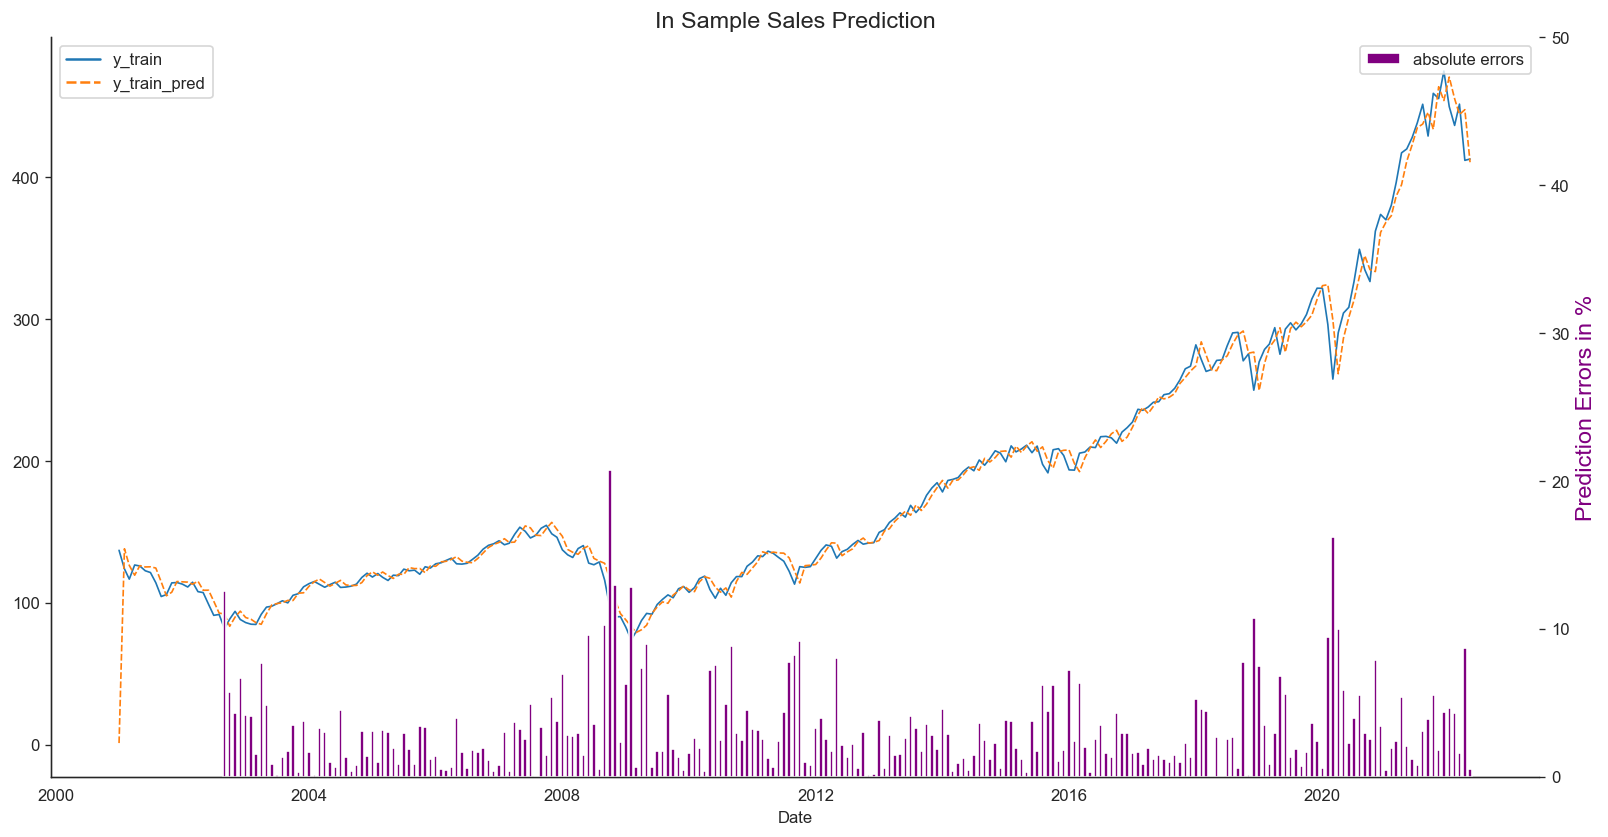

In [182]:
# Generate in-sample Predictions
# The parameter dynamic=False means that the model makes predictions upon the lagged values.
# This means that the model is trained until a point in the time-series and then tries to predict the next value.
pred = model_fit.predict_in_sample(dynamic=False) # works only with auto-arima
df_train['y_train_pred'] = pred

# Calculate the percentage difference
df_train['diff_percent'] = abs((df_train['y_train'] - pred) / df_train['y_train'])* 100

# Print the predicted time-series
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("In Sample Sales Prediction", fontsize=14)
sns.lineplot(data=df_train[['y_train', 'y_train_pred']], linewidth=1.0)

# Print percentage prediction errors on a separate axis (ax2)
ax2 = ax1.twinx() 
ax2.set_ylabel('Prediction Errors in %', color='purple', fontsize=14)  
ax2.set_ylim([0, 50])
ax2.bar(height=df_train['diff_percent'][20:], x=df_train.index[20:], width=20, color='purple', label='absolute errors')
plt.legend()
plt.show()

# Step #6 Generate and Visualize a Sales Forecast

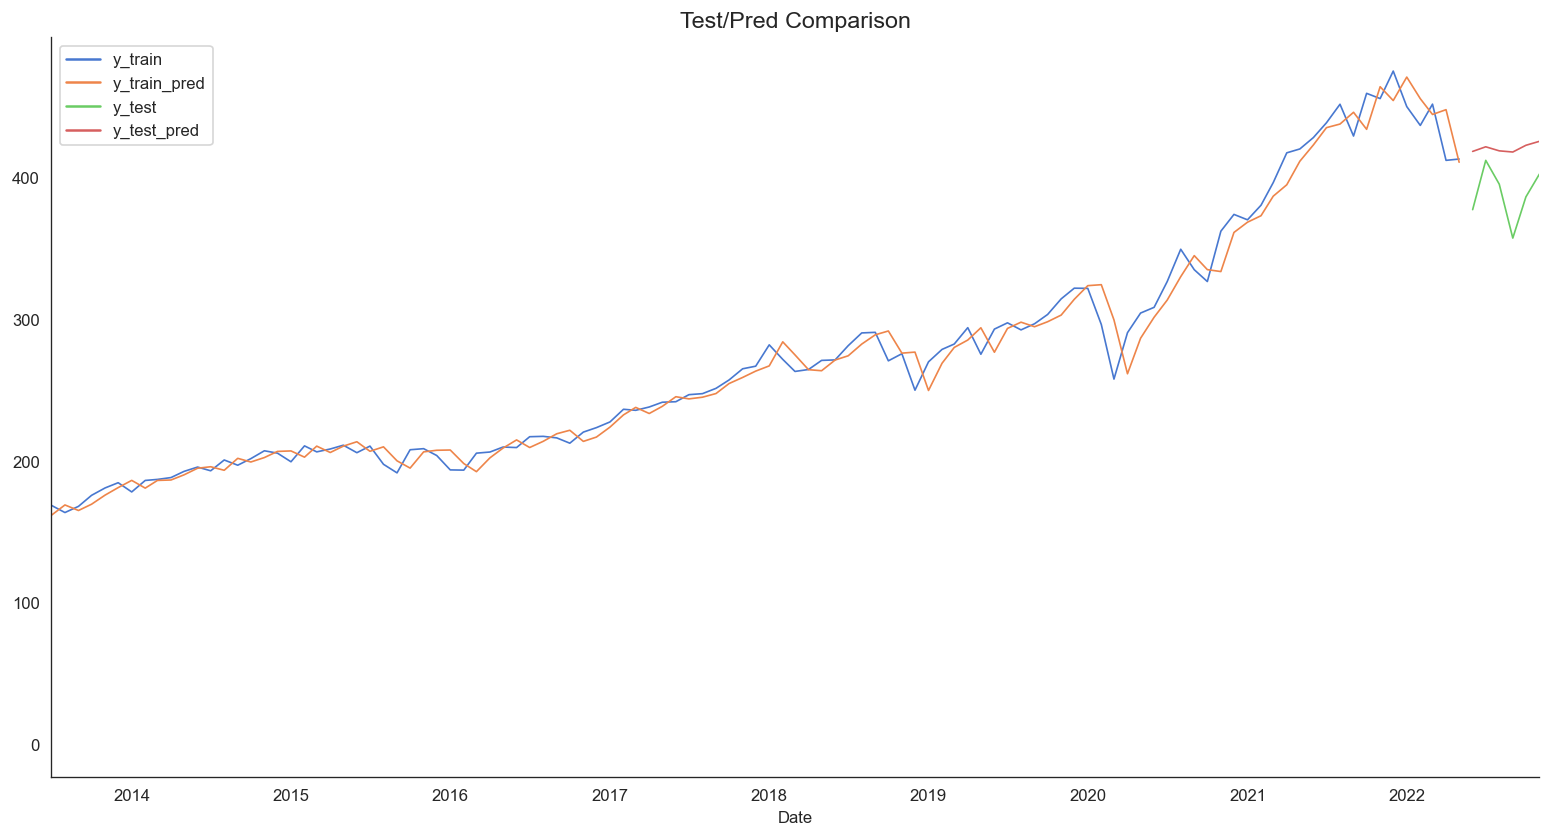

In [183]:
# Generate prediction for n periods, 
# Predictions start from the last date of the training data
test_pred = model_fit.predict(n_periods=pred_periods, dynamic=False)
df_test['y_test_pred'] = test_pred
df_union = pd.concat([df_train, df_test])
df_union.rename(columns={'beer':'y_test'}, inplace=True)

# Print the predicted time-series
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("Test/Pred Comparison", fontsize=14)
sns.despine();
sns.lineplot(data=df_union[['y_train', 'y_train_pred', 'y_test', 'y_test_pred']], linewidth=1.0, dashes=False, palette='muted')
ax.set_xlim([df_union.index[150],df_union.index.max()])
plt.legend()
plt.show()

# Step #7 Measure Performance

In [184]:
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(df_test['y_test'], df_test['y_test_pred'])/ df_test['y_test']))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(df_test['y_test'], df_test['y_test_pred'])/ df_test['y_test'])) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Mean Absolute Percentage Error (MAPE): 8.55 %
Median Absolute Percentage Error (MDAPE): 7.69 %
